# Traitement d'image de caractère

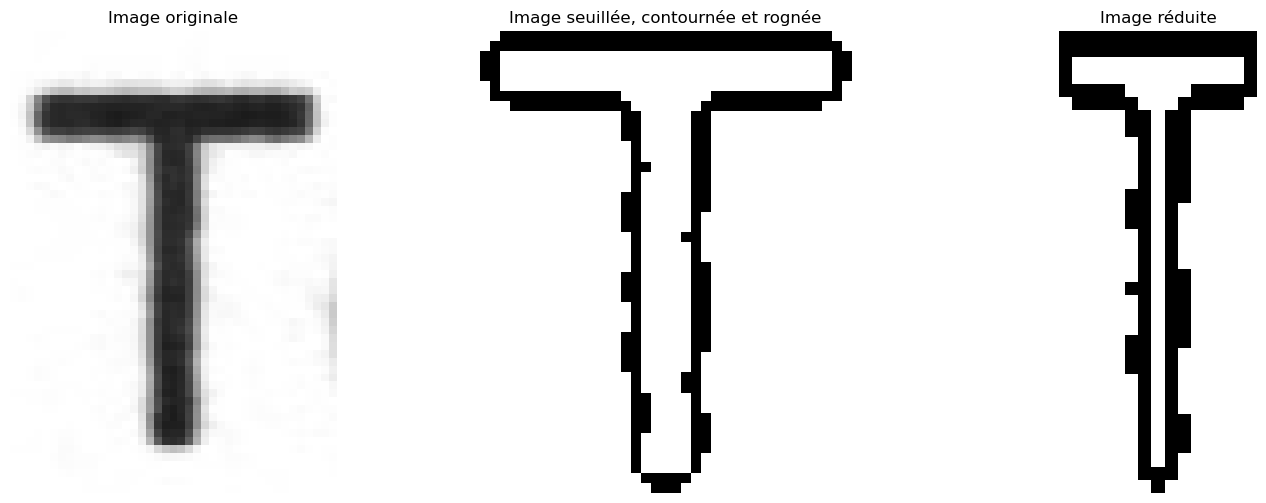

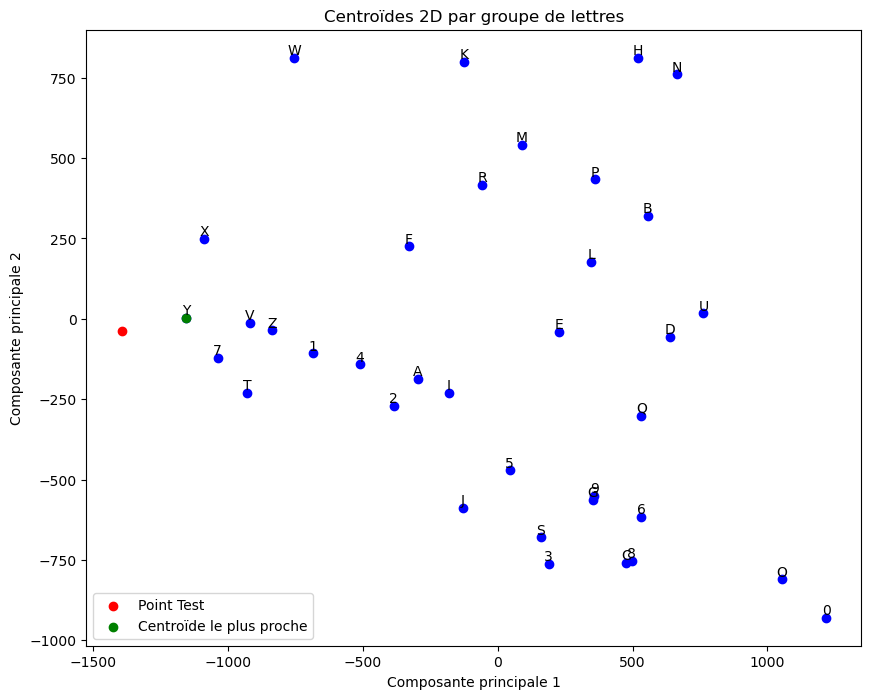

En 2D, le centroïde le plus proche est celui de la lettre : y


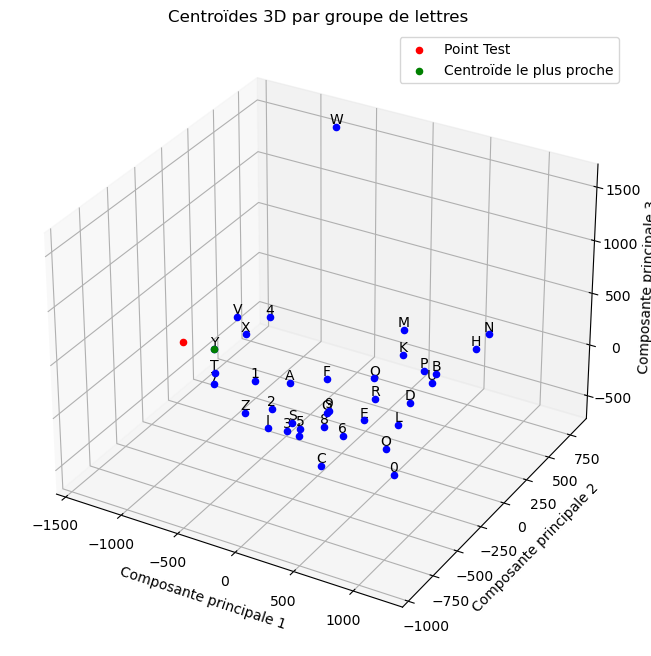

En 3D, le centroïde le plus proche est celui de la lettre : y


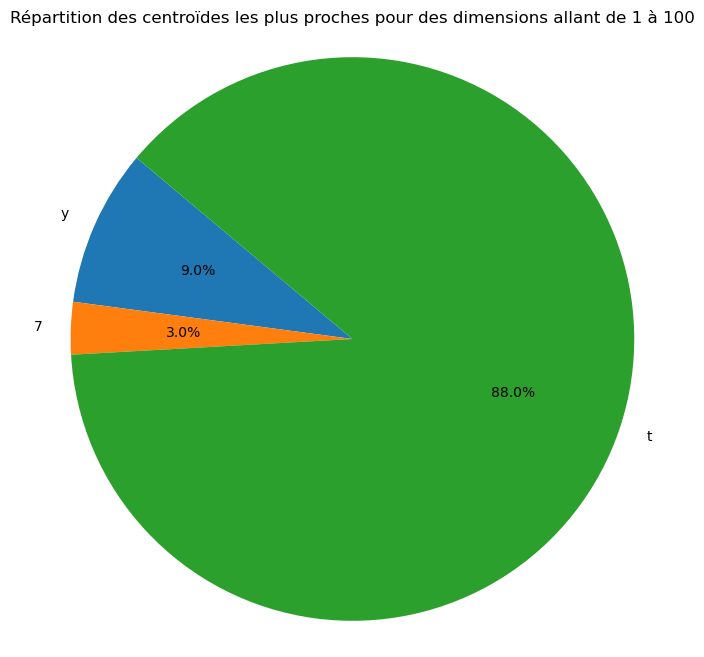

In [119]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, img_as_ubyte
from sklearn.decomposition import PCA
import os
from scipy.spatial import distance
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter




######################## Fonctions de traitement d'image ########################

def mat_gris(img_path): 
    img = Image.open(img_path)
    img_gris = img.convert('L')
    mat_gris = np.array(img_gris)
    return mat_gris

def seuillage(mat):
    seuil = filters.threshold_otsu(mat)
    mat = np.where(mat < seuil, 0, 255)
    return mat

def contourer(mat):
    g = filters.sobel(mat)
    g = (g / np.max(g)) * 2 - 1 
    g = img_as_ubyte(g)
    g = 255 - g
    g = seuillage(g)
    return g

def rogner(mat):
    mat = seuillage(mat)
    mat = contourer(mat)
    c_non_vides = np.where(np.any(mat == 0, axis=0))[0]
    l_non_vides = np.where(np.any(mat == 0, axis=1))[0]
    c_min, c_max = c_non_vides[0], c_non_vides[-1]
    l_min, l_max = l_non_vides[0], l_non_vides[-1]
    mat_rognee = mat[l_min:l_max+1, c_min:c_max+1]
    return mat_rognee

def reduire(mat, hauteur, largeur):
    img = Image.fromarray(mat)
    img_reduite = img.resize((largeur, hauteur))
    mat_reduite = np.array(img_reduite)
    return seuillage(mat_reduite)




######################## Affichage des traitements d'image ########################

img_path = "scan_niv_gris_400ppp_fiche_ocr_T.bmp"
h, l = 35, 15

original_img = Image.open(img_path)

gris_img = mat_gris(img_path)
rognee_img = rogner(gris_img)
reduit_img = reduire(rognee_img, h, l)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 ligne, 3 colonnes

axs[0].imshow(original_img, cmap='gray')
axs[0].set_title('Image originale')
axs[0].axis('off') 

axs[1].imshow(rognee_img, cmap='gray')
axs[1].set_title('Image seuillée, contournée et rognée')
axs[1].axis('off')

axs[2].imshow(reduit_img, cmap='gray')
axs[2].set_title('Image réduite')
axs[2].axis('off')


plt.show()




######################## Lettres de référence ########################

lettres_majuscules = [chr(i) for i in range(65, 91)]
lettres_minuscules = [chr(i) for i in range(97, 123)]
chiffres = [str(i) for i in range(10)]
lettres = lettres_majuscules + lettres_minuscules + chiffres
matrices = []
loaded_lettres = []

dossiers = {
    "majuscules": {
        "Arial": "Arial/Alphabet_arial_majuscule",
        "Comforta": "Comforta/Alphabet_comforta_majuscule",
        "Roboto": "Roboto/Alphabet_roboto_majuscule",
        "Verdana": "Verdana/Alphabet_verdana_majuscule",
        "Comic_sans_MS": "Comic_sans_MS/Alphabet_comic_sans_MS_majuscule",
        "Times new roman": "Times new roman/Alphabet_times new roman_majuscule",
        "Georgia": "Georgia/Alphabet_georgia_majuscule",
        
    },
    "minuscules": {
        "Arial": "Arial/Alphabet_arial_minuscule",
        "Georgia": "Georgia/Alphabet_georgia_minuscule",
        "Roboto": "Roboto/Alphabet_roboto_minuscule",
        "Verdana": "Verdana/Alphabet_verdana_minuscule",
        "Comic_sans_MS": "Comic_sans_MS/Alphabet_comic_sans_MS_minuscule",
        "Times new roman": "Times new roman/Alphabet_times new roman_minuscule",
        "Georgia": "Georgia/Alphabet_georgia_minuscule",
        
    },
    "chiffres": {
        "Arial": "Arial/Alphabet_arial_chiffres",
        "Georgia": "Georgia/Alphabet_georgia_chiffres",
        "Roboto": "Roboto/Alphabet_roboto_chiffres",
        "Verdana": "Verdana/Alphabet_verdana_chiffres",
        "Comic_sans_MS": "Comic_sans_MS/Alphabet_comic_sans_MS_chiffres",
        "Times new roman": "Times new roman/Alphabet_times new roman_chiffres",
        "Georgia": "Georgia/Alphabet_georgia_chiffres",
    } 
}

for type_alphabet, dossiers in dossiers.items():
    lettres_type = lettres
    for lettre in lettres_type:
        for font, dossier_path in dossiers.items():
            img = os.path.join(dossier_path, f"{lettre}.png")
            if os.path.isfile(img):
                mat = mat_gris(img)
                mat = rogner(mat)
                mat = reduire(mat, h,l)
                matrices.append(mat.flatten())
                loaded_lettres.append(lettre)
                
                
                
                
######################## PCA 2D ########################

def project_to_2d(mat):
    pca = PCA(n_components=2)
    if len(mat.shape) > 2:
        mat = mat.reshape(mat.shape[0], -1)
    mat_2d = pca.fit_transform(mat)
    return mat_2d

matrices = np.array(matrices)
mat_test = mat_gris(img_path)
mat_test = rogner(mat_test)
mat_test = reduire(mat_test, h,l)
matrices_test = np.append(matrices, mat_test.flatten().reshape(1, -1), axis=0)

pca_2d = PCA(n_components=2)
matrices_2d = pca_2d.fit_transform(matrices)

matrices_2d_test = pca_2d.transform(matrices_test)
mat_2d_test = matrices_2d_test[-1]

centroids_2d = {}
for lettre in set(loaded_lettres):
    indices = [i for i, l in enumerate(loaded_lettres) if l.lower() == lettre]
    if indices:  # Vérifie si la liste n'est pas vide
        group_points = matrices_2d[indices]
        centroid = np.mean(group_points, axis=0)
        centroids_2d[lettre] = centroid

plt.figure(figsize=(10, 8))
for lettre, centroid in centroids_2d.items():
    plt.scatter(centroid[0], centroid[1], color='blue')  
    plt.text(centroid[0], centroid[1] + 1, lettre.upper(), ha='center', va='bottom')  

plt.scatter(mat_2d_test[0], mat_2d_test[1], color='red', label='Point Test')  
distances_2d = distance.cdist([mat_2d_test], np.array([centroid for centroid in centroids_2d.values()]))
closest_centroid_index_2d = np.argmin(distances_2d)
closest_letter_2d = list(centroids_2d.keys())[closest_centroid_index_2d]
plt.scatter(centroids_2d[closest_letter_2d][0], centroids_2d[closest_letter_2d][1], color='green', label='Centroïde le plus proche')  # Centroïde le plus proche en vert
plt.legend()
plt.title('Centroïdes 2D par groupe de lettres')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.show()

print(f"En 2D, le centroïde le plus proche est celui de la lettre : {closest_letter_2d}")




######################## PCA 3D ########################

pca_3d = PCA(n_components=3)
matrices_3d = pca_3d.fit_transform(matrices)

matrices_3d_test = pca_3d.transform(matrices_test)
mat_3d_test = matrices_3d_test[-1]

centroids_3d = {}
for lettre in set(loaded_lettres):
    indices = [i for i, l in enumerate(loaded_lettres) if l.lower() == lettre]
    if indices:
        group_points = matrices_3d[indices]
        centroid = np.mean(group_points, axis=0)
        centroids_3d[lettre] = centroid

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for lettre, centroid in centroids_3d.items():
    ax.scatter(centroid[0], centroid[1], centroid[2], color='blue') 
    ax.text(centroid[0], centroid[1], centroid[2] + 1, lettre.upper(), ha='center', va='bottom')  
    
ax.scatter(mat_3d_test[0], mat_3d_test[1], mat_3d_test[2], color='red', label='Point Test')
distances_3d = distance.cdist([mat_3d_test], np.array([centroid for centroid in centroids_3d.values()]))
closest_centroid_index_3d = np.argmin(distances_3d)
closest_letter_3d = list(centroids_3d.keys())[closest_centroid_index_3d]
ax.scatter(centroids_3d[closest_letter_3d][0], centroids_3d[closest_letter_3d][1], centroids_3d[closest_letter_3d][2], color='green', label='Centroïde le plus proche')  # Centroïde le plus proche en vert
ax.legend()
plt.title('Centroïdes 3D par groupe de lettres')
ax.set_xlabel('Composante principale 1')
ax.set_ylabel('Composante principale 2')
ax.set_zlabel('Composante principale 3')
plt.show()

print(f"En 3D, le centroïde le plus proche est celui de la lettre : {closest_letter_3d}")




######################## PCA de 1D à 100D ########################

overall_letter_counter = Counter()

for n_components in range(1, 101):
    letter_counter = Counter()
    pca_nd = PCA(n_components=n_components)
    matrices_nd = pca_nd.fit_transform(matrices)
    matrices_nd_test = pca_nd.transform(matrices_test)
    mat_nd_test = matrices_nd_test[-1]
    centroids_nd = {}
    
    for lettre in set(loaded_lettres):
        indices = [i for i, l in enumerate(loaded_lettres) if l.lower() == lettre]
        group_points = matrices_nd[indices]
        if len(group_points) > 0:
            centroid = np.mean(group_points, axis=0)
            centroids_nd[lettre] = centroid

    distances_nd = distance.cdist([mat_nd_test], [centroids_nd[lettre] for lettre in centroids_nd])
    closest_centroid_index_nd = np.argmin(distances_nd)
    closest_letter_nd = list(centroids_nd.keys())[closest_centroid_index_nd]
    
    letter_counter[closest_letter_nd] += 1
    
    overall_letter_counter.update(letter_counter)

labels = overall_letter_counter.keys()
sizes = overall_letter_counter.values()

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Répartition des centroïdes les plus proches pour des dimensions allant de 1 à 100')
plt.show()

In [118]:
pip install pandas